# Destination Prediction

We want to predict the destination of a driver based on the beginning of its trip. We will use various fractions of the trip from the beginning and see how they allow us to better predict the destination.

In [10]:
%pylab inline
import torch
from torch import nn
import torch.nn.functional as F
from torch import optim

import numpy as np
import os
import sys

Populating the interactive namespace from numpy and matplotlib


/misc/DLshare/home/rpcqf578/anaconda3/envs/workshop/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['copy']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [11]:
from src.destination_prediction.utils import *
from src.destination_prediction.model import DestinationLSTM, DestinationLSTMClf
from src.destination_prediction.train import train, evaluate, train_clf, evaluate_clf


### Downloading the dataset
We first download the GeoLife Trajectories dataset from Microsoft.

In [12]:
download_data()

Data has already been downloaded!


### Analyzing the trip length distribution
We first have a look at the data to see what's the distribution of the trip lengths.

Creating a histogram showing the trip length distribution...


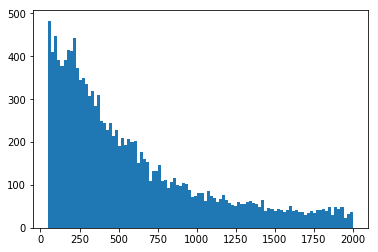

In [4]:
show_trip_length_distribution()

We decide to keep trips of length between 50 and 2000 to train our model. (I already cropped the trips that were shorter or longer than that in the histogram)

### Analyzing GPS position distribution
Let's see where the majority of the trips are concentrated

Creating histograms showing the position distribution...


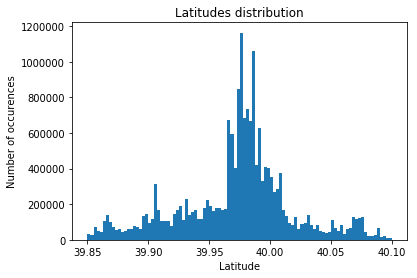

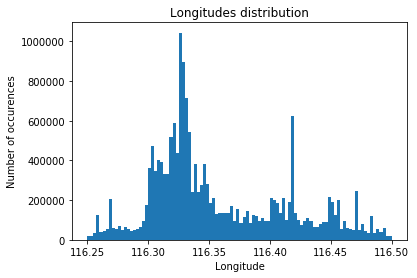

In [3]:
show_position_distribution()

We find that the majority of trips are between longitudes 116.25 and 116.50 and between latitudes 39.85 and 40.10. This is located in Beijing, China. We decide only to keep these values. This will help use reduce the search space in order to make better predictions.

### Splitting the dataset into train, valid, test sets
This creates `train.json`, `valid.json` and `test.json` files containing the datasets. We standardize and randomize the data at the same time.

In [9]:
create_datasets()

Splitting the dataset into train, valid, dev ...
Saving the datasets created...


### Loading the data 

We first load the data from the json files and then we split them in batches to accelerate the LSTM's training. Before splitting into batches, we sort the trips by length so that none of the trips are padded too much.

In [13]:
import json

# loading datasets from json file
with open(os.path.join(os.getcwd(), "geolife_trajectories", "train.json")) as json_data:
    train_dset = json.load(json_data)

with open(os.path.join(os.getcwd(), "geolife_trajectories", "valid.json")) as json_data:    
    valid_dset = json.load(json_data)
    
with open(os.path.join(os.getcwd(), "geolife_trajectories", "test.json")) as json_data:
    test_dset = json.load(json_data)
    
with open(os.path.join(os.getcwd(), "geolife_trajectories", "mean_std.json")) as json_data:
    mean_std_data = json.load(json_data)


In [84]:
#creating batched version of the datasets
batched_train_dset = create_batched_dset(train_dset, batch_size=128)
batched_valid_dset = create_batched_dset(valid_dset, batch_size=1)
batched_test_dset = create_batched_dset(test_dset, batch_size=1)

### Creating our model
We use a LSTM network as our model to predict the destination of the trip. We use this model because the length of trips varies and LSTMs can take inputs of variable lengths. We have two different linear layers to predict both the longitude and the latitude of the destination.

In [30]:
model = DestinationLSTM().to(device)

### Training our model
We train the model using different fractions of the beginning of our trip.

We first sort the trips of each dataset by length so that the training time is reduced a bit

In [31]:
train(model, batched_train_dset, mean_std_data, batched_valid_dset, n_epochs=25, start_lr=1e-2, trip_frac=.5)

Epoch 0 ----- mean distance error : 3.612 ----- mean valid distance error : 4.633
Epoch 1 ----- mean distance error : 3.622 ----- mean valid distance error : 4.656
Epoch 2 ----- mean distance error : 3.576 ----- mean valid distance error : 4.632
Epoch 3 ----- mean distance error : 3.615 ----- mean valid distance error : 4.622
Epoch 4 ----- mean distance error : 3.604 ----- mean valid distance error : 4.659
Epoch 5 ----- mean distance error : 3.589 ----- mean valid distance error : 4.619
Epoch 6 ----- mean distance error : 3.627 ----- mean valid distance error : 4.655
Epoch 7 ----- mean distance error : 3.663 ----- mean valid distance error : 4.680
Epoch 8 ----- mean distance error : 3.696 ----- mean valid distance error : 4.696
Epoch 9 ----- mean distance error : 3.646 ----- mean valid distance error : 4.648
Epoch 10 ----- mean distance error : 3.652 ----- mean valid distance error : 4.658
Epoch 11 ----- mean distance error : 3.635 ----- mean valid distance error : 4.635
Epoch 12 -----

### Show results on the map

Here we show the predicted destination given the beginning of a trip.

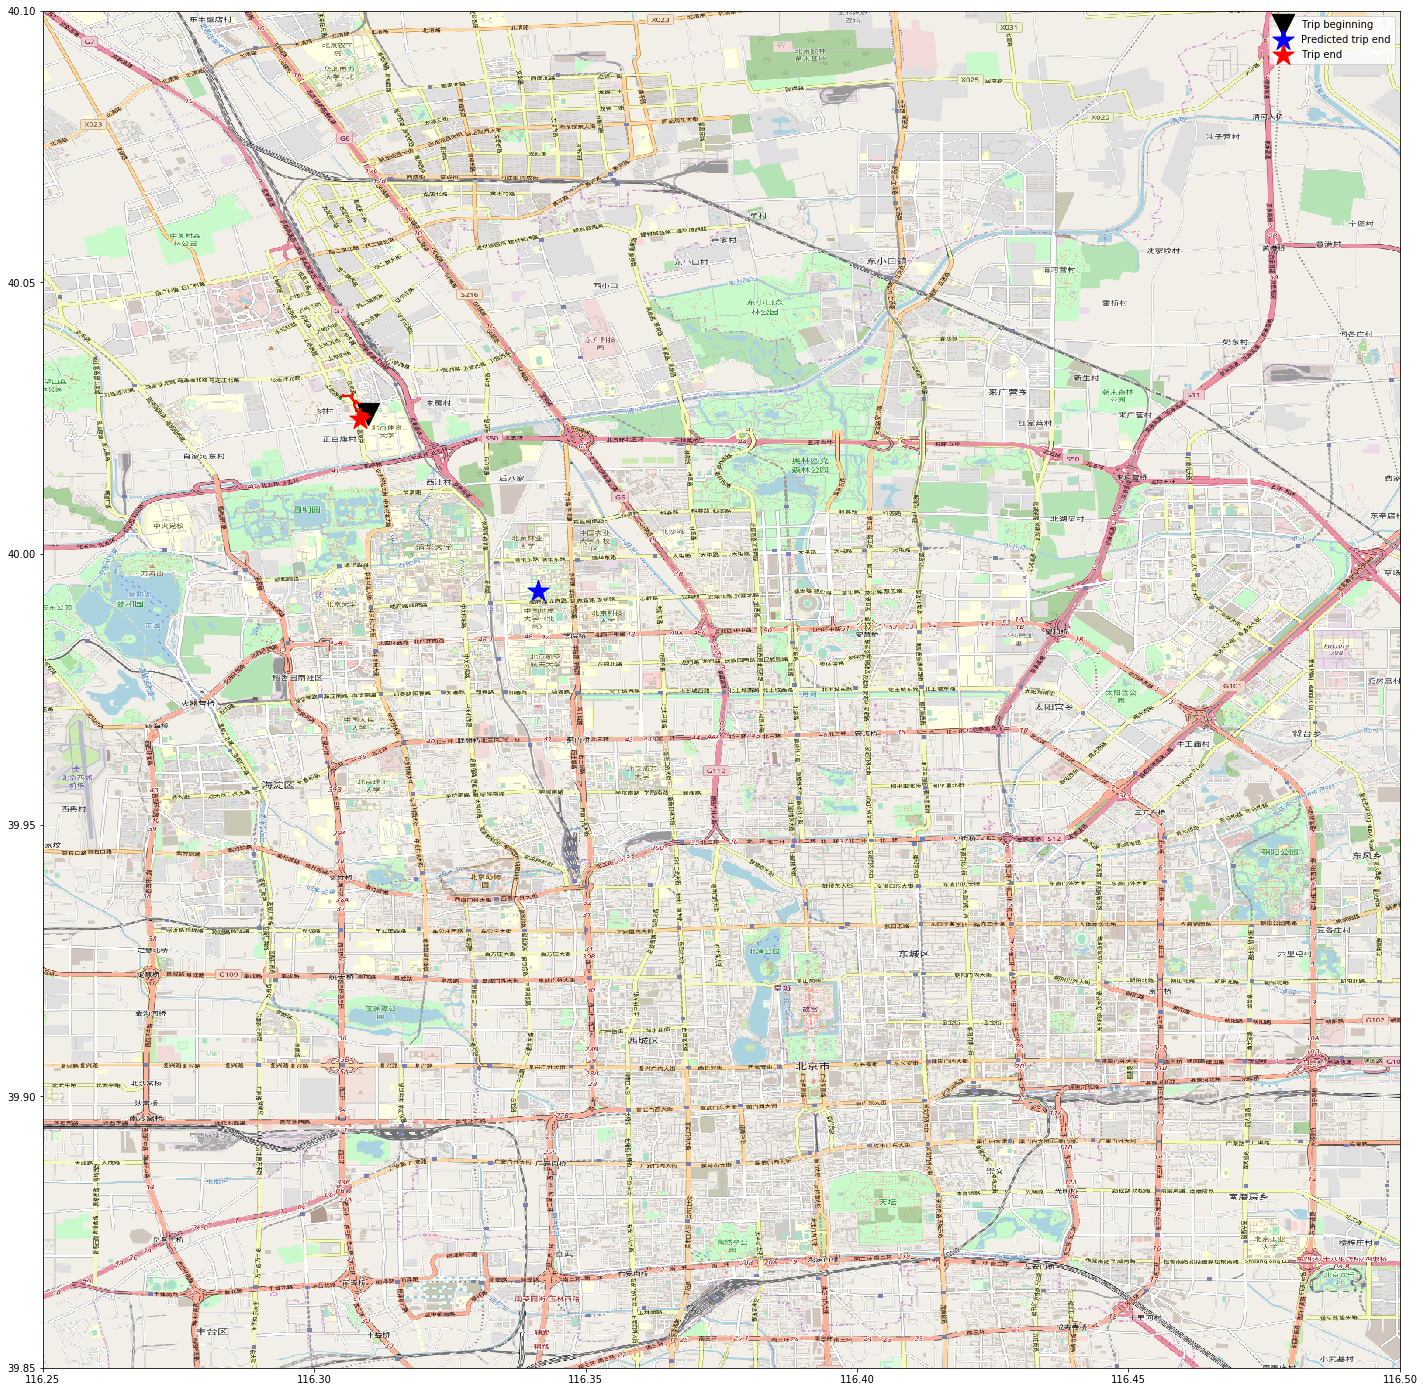

In [47]:
# pick a trip
trip = batched_valid_dset[79]
trajectory = trip[0]
end = trip[1]

# preprocess it
trip_frac = 0.1
inputs = trajectory.to(device)
targets = end.to(device)

# truncate trip to keep only beginning
inputs = inputs[:int(trip_frac*inputs.shape[0])]

# standardize inputs and targets
inputs[:,:,0] = (inputs[:,:,0] - mean_std_data["mean_lat"]) / mean_std_data["std_lat"]
inputs[:,:,1] = (inputs[:,:,1] - mean_std_data["mean_long"]) / mean_std_data["std_long"]

targets[:,0] = (targets[:,0] - mean_std_data["mean_lat"]) / mean_std_data["std_lat"]
targets[:,1] = (targets[:,1] - mean_std_data["mean_long"]) / mean_std_data["std_long"]

# predict output
out_lat, out_long = model(inputs)

# compute mean distance error (km)
# n_pts += inputs.shape[1]

out_lat = out_lat.squeeze().data.to('cpu').numpy()
out_long = out_long.squeeze().data.to('cpu').numpy()
tgt_lat = targets[:,0].squeeze().to('cpu').numpy()
tgt_long = targets[:,1].squeeze().to('cpu').numpy()

# un-standardize data
out_lat = out_lat * mean_std_data["std_lat"] + mean_std_data["mean_lat"]
out_long = out_long * mean_std_data["std_long"] + mean_std_data["mean_long"]
tgt_lat = tgt_lat * mean_std_data["std_lat"] + mean_std_data["mean_lat"]
tgt_long = tgt_long * mean_std_data["std_long"] + mean_std_data["mean_long"]

# print map of Beijing
img=plt.imread('figures/map.png')
plt.figure(figsize = (24.32,31.64))
imgplot = plt.imshow(img, extent=(116.25, 116.5, 39.85, 40.1))

# plot trip, destination and predicted destination

plt.plot(trajectory[:,:,1].numpy(), trajectory[:,:,0].numpy(), 'r')
plt.scatter(trajectory[0,:,1].numpy(), trajectory[0,:,0].numpy(), c='k', marker='v', s=500, label="Trip beginning")
plt.scatter(out_long, out_lat, c='b', marker='*', s=500, label="Predicted trip end")
plt.scatter(tgt_long, tgt_lat, c='r', marker='*', s=500, label="Trip end")

plt.legend(fancybox=True)

plt.show()

In [48]:
import osmnx as ox

In [49]:
# instead of doing a regression on the longitudes and latitudes, could do a classification on the nearest destination nodes

import osmnx as ox

north, south, east, west = (40.10, 39.85, 116.50, 116.25)
G = ox.graph_from_bbox(north, south, east, west, network_type='all')

In [50]:
import copy
import networkx as nx

# creating mapping to have nodes labeled from 0 to nb_of_nodes
mapping = {}
for i, node in enumerate(G.nodes):
    mapping[node] = i

# creating new graph with said mapping
H = nx.relabel_nodes(G, mapping)


In [85]:
model = DestinationLSTMClf(graph=H).to(device)

In [ ]:
train_clf(model, batched_train_dset, mean_std_data, batched_valid_dset, n_epochs=25, start_lr=1e-2, trip_frac=.5)

Epoch 0 ----- mean distance error : 4.260 ----- mean valid distance error : 4.842


In [ ]:
# model = DestinationLSTMClf(graph=H).to(device)
# train_clf(model, [batched_train_dset[0]], mean_std_data, [batched_valid_dset[0]], n_epochs=100, start_lr=1e-3, trip_frac=1.)

[[39.89501  39.894993 39.89504  39.89504  39.89504  39.89505  39.895058
  39.89505  39.89505  39.89505  39.89505  39.895054 39.895077 39.895103
  39.89512  39.895134 39.89514  39.895157 39.895195 39.895233 39.895252
  39.895287 39.895313 39.895325 39.895317 39.895325 39.895325 39.895325
  39.895332 39.89535  39.89538  39.89541  39.89543  39.895424 39.895443
  39.895443 39.895466 39.89552  39.89556  39.895584 39.895596 39.895596
  39.895638 39.89563  39.89564  39.89565  39.895657 39.89564  39.895645
  39.89566  39.89566  39.895668 39.8957   39.895733 39.895786 39.89586
  39.895927 39.89597  39.895992 39.89593  39.89592  39.895927 39.895947
  39.89595  39.895943 39.89594  39.895927 39.89592  39.895916 39.89591
  39.89589  39.895893 39.895897 39.895897 39.895897 39.89589  39.89588
  39.89591  39.895905 39.895905 39.89589  39.89588  39.895878 39.895885
  39.895927 39.895935 39.895943 39.895958 39.89596  39.895973 39.895973
  39.895977 39.89598  39.89599  39.895985 39.895977 39.895973 39.89

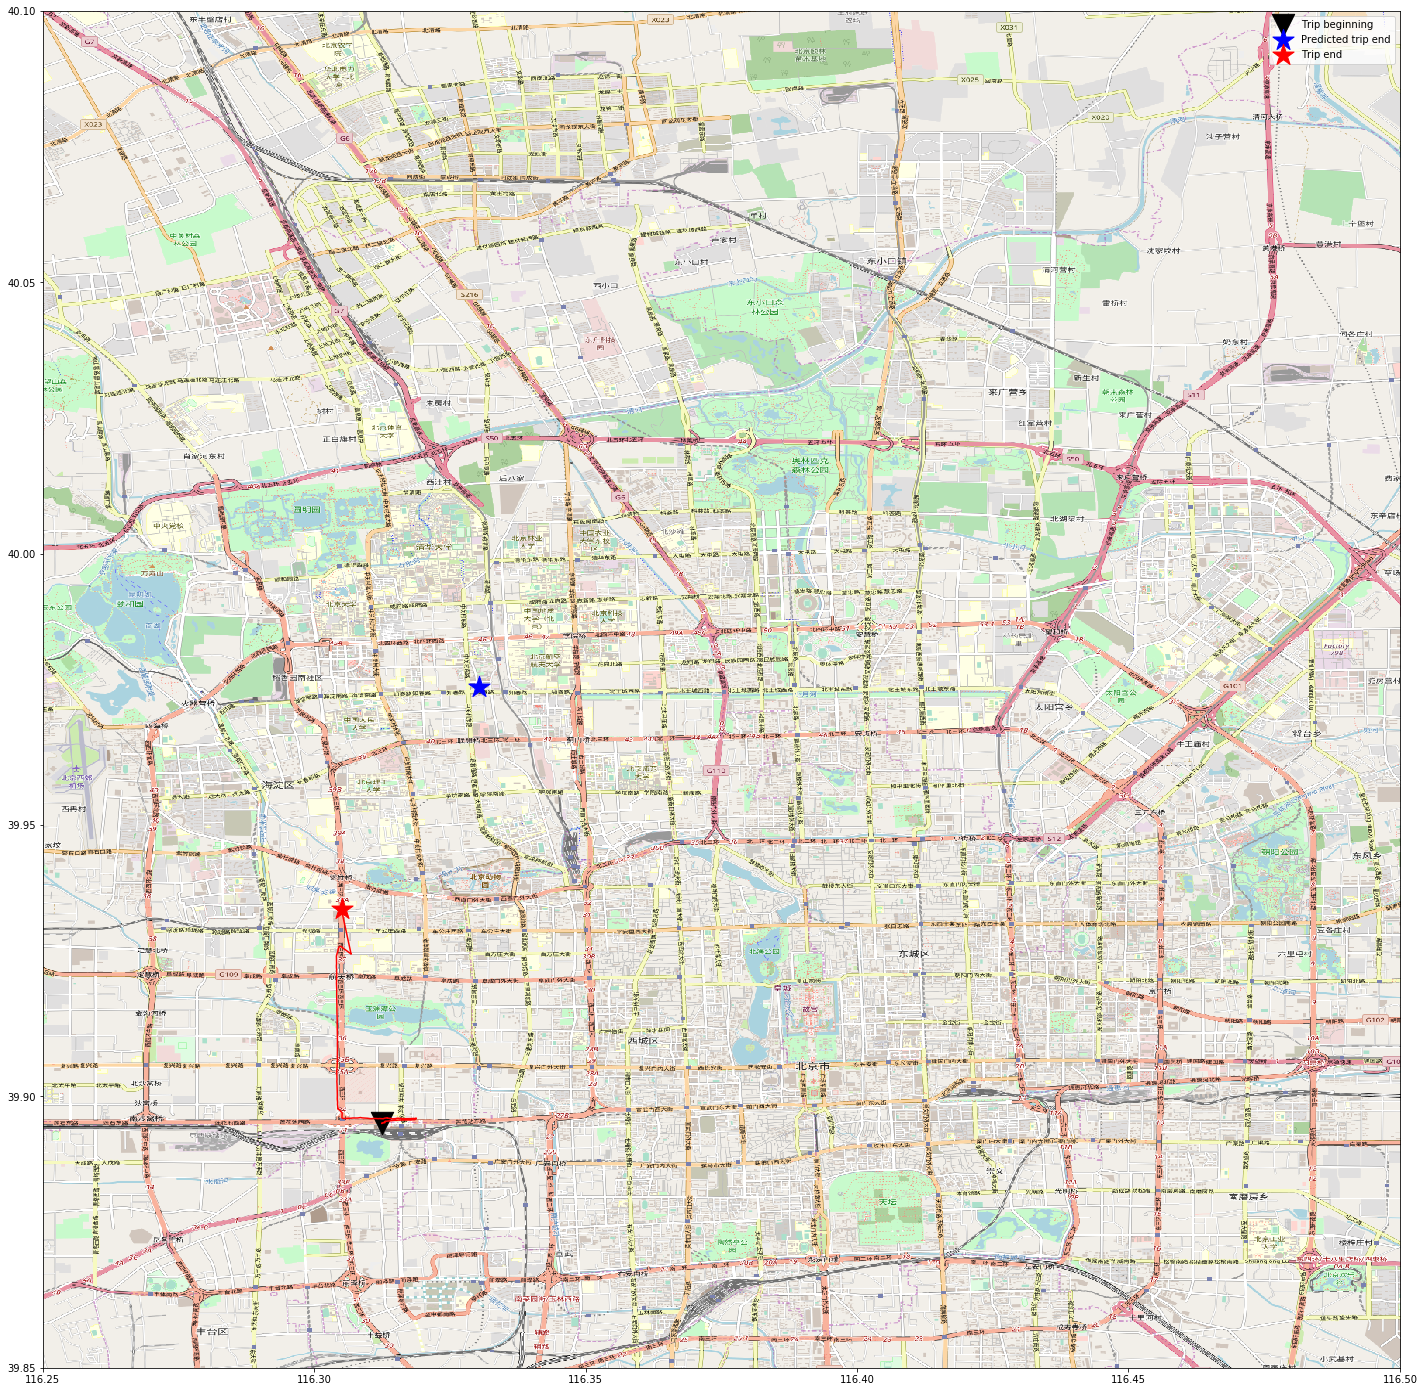

In [83]:
# pick a trip
trip = batched_valid_dset[89]
trajectory = trip[0]
end = trip[1]

# preprocess it
trip_frac = .5
inputs = trajectory.to(device)
targets = end.to(device)

# truncate trip to keep only beginning
inputs = inputs[:int(trip_frac*inputs.shape[0])]

# standardize inputs and targets
inputs[:,:,0] = (inputs[:,:,0] - mean_std_data["mean_lat"]) / mean_std_data["std_lat"]
inputs[:,:,1] = (inputs[:,:,1] - mean_std_data["mean_long"]) / mean_std_data["std_long"]

# predict output
output = model(inputs)

# compute mean distance error (km)
# n_pts += inputs.shape[1]

predicted_nodes = torch.argmax(output, dim=1).to('cpu').numpy()

out_long = np.zeros(len(targets))
out_lat = np.zeros(len(targets))
for i in range(len(predicted_nodes)):
    out_long[i] = model.graph.node[predicted_nodes[i]]['x']
    out_lat[i] = model.graph.node[predicted_nodes[i]]['y']

tgt_lat = targets[:,0].squeeze().to('cpu').numpy()
tgt_long = targets[:,1].squeeze().to('cpu').numpy()

# print map of Beijing
img=plt.imread('figures/map.png')
plt.figure(figsize = (24.32,31.64))
imgplot = plt.imshow(img, extent=(116.25, 116.5, 39.85, 40.1))

# plot trip, destination and predicted destination

print(trajectory[:,:,0].numpy().T)

plt.plot(trajectory[:,:,1].numpy(), trajectory[:,:,0].numpy(), 'r')
plt.scatter(trajectory[0,:,1].numpy(), trajectory[0,:,0].numpy(), c='k', marker='v', s=500, label="Trip beginning")
plt.scatter(out_long, out_lat, c='b', marker='*', s=500, label="Predicted trip end")
plt.scatter(tgt_long, tgt_lat, c='r', marker='*', s=500, label="Trip end")

plt.legend(fancybox=True)

plt.show()

